### Importing Libraries

In [79]:
import sys
import os
import math
import time
import pandas as pd
from glob import iglob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
#import lime
#import lime.lime_tabular

### Importing dataset

In [80]:
benign=pd.read_csv("BabyMonitor/benign_traffic.csv")
x_train, x_opt, x_test = np.split(benign.sample(frac=1, random_state=17), [int(1/3*len(benign)), int(2/3*len(benign))])

df_mirai = pd.concat((pd.read_csv(f) for f in iglob('BabyMonitor/mirai/*.csv', recursive=False)), ignore_index=True)
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('BabyMonitor/gafgyt/*.csv', recursive=False)), ignore_index=True)

In [54]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'malicious'

df_ben = x_train.copy()
df_ben['class'] = 'benign'

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

### Plotting samples of benign and malicious data

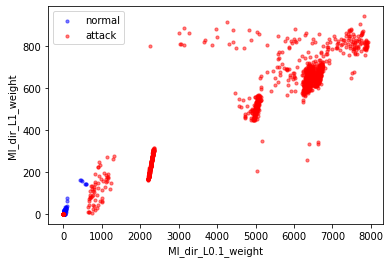

In [11]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()
plt.show()

In [45]:
classes = ['benign','malicious']
scored = []
indices = {}
shps = {}

#classifying benign as true and attack as false
for cl in classes:
    indices[cl] = df_ben['class'] == cl    
    shps[cl] =  df_ben[indices[cl]].shape[0]
        
for col in df_ben.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_ben[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_ben.shape[0]) * (m - df_ben[indices[cl]][col].mean())**2
        den += (shps[cl] / df_ben.shape[0]) * df_ben[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'MI_dir_L0.1_weight', 'score': 1.2240810634300796},
 {'feature': 'H_L0.1_weight', 'score': 1.2240810502737431},
 {'feature': 'MI_dir_L1_weight', 'score': 1.2045402024555407},
 {'feature': 'H_L1_weight', 'score': 1.204540198657306},
 {'feature': 'MI_dir_L3_weight', 'score': 1.2042752745290892}]

### Predicting Anomaly

In [25]:
class AnomalyModel:
    #initialize model
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    #predict the outcome using treshold
    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)
    
    #scale the classes
    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)
        print(classes_arr)

        return np.array(classes_arr)

### Model creation - Deep autoencoder

In [24]:
def deep_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

### Fit model

In [26]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = deep_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",monitor='val_loss',save_best_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary())    

Epoch 1/100
1826/1826 [==============================] - 9s 4ms/step - loss: 0.4509 - val_loss: 0.1836
Epoch 2/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.1723 - val_loss: 0.1340
Epoch 3/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.1268 - val_loss: 0.1067
Epoch 4/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.0949 - val_loss: 0.0761
Epoch 5/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.0756 - val_loss: 0.0795
Epoch 6/100
1826/1826 [==============================] - 8s 5ms/step - loss: 0.0709 - val_loss: 0.0641
Epoch 7/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.0581 - val_loss: 0.0590
Epoch 8/100
1826/1826 [==============================] - 6s 4ms/step - loss: 0.0603 - val_loss: 0.0525
Epoch 9/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.0523 - val_loss: 0.0561
Epoch 10/100
1826/1826 [==============================] - 5s 3ms/step - l

### Predict train dataset

In [27]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

Selecting n------------------
For n 1
Accuracy
0.8795901597247188
Precision 0.9691506918877746
Recall 0.7841405166658106
Confusion Matrix [[56955  1458]
 [12609 45804]]
For n 2
Accuracy
0.8845633677434818
Precision 0.9812541508665938
Recall 0.7841062777121531
Confusion Matrix [[57538   875]
 [12611 45802]]
For n 3
Accuracy
0.887174087959872
Precision 0.9877080997153455
Recall 0.7841062777121531
Confusion Matrix [[57843   570]
 [12611 45802]]
For n 4
Accuracy
0.888543646106175
Precision 0.9911278455812343
Recall 0.7841062777121531
Confusion Matrix [[58003   410]
 [12611 45802]]
For n 5
Accuracy
0.8896649718384606
Precision 0.9939454438922767
Recall 0.7841062777121531
Confusion Matrix [[58134   279]
 [12611 45802]]
For n 6
Accuracy
0.8901357574512523
Precision 0.995133185590753
Recall 0.7841062777121531
Confusion Matrix [[58189   224]
 [12611 45802]]
For n 7
Accuracy
0.8905466248951432
Precision 0.9962368398155399
Recall 0.7840549192816667
Confusion Matrix [[58240   173]
 [12614 45799]]


### Test data

In [28]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
deep_tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
deep_acc = accuracy_score(Y_test, Y_pred)
deep_precision = precision_score(Y_test, Y_pred)
deep_recall = recall_score(Y_test, Y_pred)
deep_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',deep_acc)
print('Precision ',deep_precision)
print("Recall",deep_recall)
print('Confusion Matrix',deep_cm)
   
#print(accs)

Test-----------------
best n 28
Treshold  8.203981410665348
Accuracy  0.892594241106584
Precision  0.9997602859135286
Recall 0.7853767932344986
Confusion Matrix [[58403    11]
 [12537 45877]]


### Variational Autoencoder

In [32]:
def vae_model(input_dim):
    original_dim = input_dim
    intermediate_dim = 64
    latent_dim = 2

    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    from keras import backend as K

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    return Model(inputs, outputs, name='vae_mlp')


In [33]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = vae_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_vae.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.9020 - val_loss: 0.8542
Epoch 2/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.8095 - val_loss: 0.8528
Epoch 3/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.8132 - val_loss: 0.8501
Epoch 4/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.8293 - val_loss: 0.8485
Epoch 5/100
1826/1826 [==============================] - 8s 4ms/step - loss: 0.8275 - val_loss: 0.8479
Epoch 6/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.7986 - val_loss: 0.8473
Epoch 7/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.8294 - val_loss: 0.8473
Epoch 8/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.7422 - val_loss: 0.8463
Epoch 9/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.7898 - val_loss: 0.8459- ETA: 0s - loss: 0.78
Epoch 10/100
1826/1826 [===========================

### Train

In [34]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9882474791570369
Precision 0.9771464899953155
Recall 0.9998801636621985
Confusion Matrix [[57047  1366]
 [    7 58406]]
For n 2
Accuracy
0.9914488213240203
Precision 0.9833804809052333
Recall 0.9997945662780545
Confusion Matrix [[57426   987]
 [   12 58401]]
For n 3
Accuracy
0.9929382158081249
Precision 0.9862701388185227
Recall 0.9997945662780545
Confusion Matrix [[57600   813]
 [   12 58401]]
For n 4
Accuracy
0.9943505726465
Precision 0.9890426270597998
Recall 0.9997774468012257
Confusion Matrix [[57766   647]
 [   13 58400]]
For n 5
Accuracy
0.9957458100080462
Precision 0.9917804496977107
Recall 0.9997774468012257
Confusion Matrix [[57929   484]
 [   13 58400]]
For n 6
Accuracy
0.9967045007104582
Precision 0.9936704553188593
Recall 0.9997774468012257
Confusion Matrix [[58041   372]
 [   13 58400]]
For n 7
Accuracy
0.9969784123397188
Precision 0.9942117807286347
Recall 0.9997774468012257
Confusion Matrix [[58073   340]
 [   13 58400]]


### Test

In [35]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
vae_acc = accuracy_score(Y_test, Y_pred)
vae_precision = precision_score(Y_test, Y_pred)
vae_recall = recall_score(Y_test, Y_pred)
vae_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',vae_acc)
print('Precision ',vae_precision)
print("Recall",vae_recall)
print('Confusion Matrix',vae_cm)

Test-----------------
best n 8
Treshold  48.64811228086002
Accuracy  0.9972523710069504
Precision  0.9948212125858162
Recall 0.9997089738761256
Confusion Matrix [[58110   304]
 [   17 58397]]


### Sparse Autoencoder

In [48]:
def sparse_model(input_dim):
    hidden_size=90
    code_size = 57
    input_img = Input(shape=(input_dim,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_dim, activation='sigmoid')(hidden_2)
    sparse = Model(input_img, output_img)
    return sparse

In [49]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = sparse_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1826/1826 [==============================] - 10s 4ms/step - loss: 0.8977 - val_loss: 0.8378
Epoch 2/100
1826/1826 [==============================] - 8s 4ms/step - loss: 0.8173 - val_loss: 0.8348
Epoch 3/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8364 - val_loss: 0.8337
Epoch 4/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.7784 - val_loss: 0.8331
Epoch 5/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.8167 - val_loss: 0.8311
Epoch 6/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8309 - val_loss: 0.8310
Epoch 7/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8086 - val_loss: 0.8293
Epoch 8/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8131 - val_loss: 0.8291
Epoch 9/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8174 - val_loss: 0.8291
Epoch 10/100
1826/1826 [==============================] - 6s 3ms/step - 

In [50]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9884015544484961
Precision 0.9774408407805335
Recall 0.9998801636621985
Confusion Matrix [[57065  1348]
 [    7 58406]]
For n 2
Accuracy
0.9914916200160923
Precision 0.9834632807369112
Recall 0.9997945662780545
Confusion Matrix [[57431   982]
 [   12 58401]]
For n 3
Accuracy
0.9929467755465393
Precision 0.986286795129448
Recall 0.9997945662780545
Confusion Matrix [[57601   812]
 [   12 58401]]
For n 4
Accuracy
0.9943334531696711
Precision 0.9890091280123288
Recall 0.9997774468012257
Confusion Matrix [[57764   649]
 [   13 58400]]
For n 5
Accuracy
0.9957458100080462
Precision 0.9917804496977107
Recall 0.9997774468012257
Confusion Matrix [[57929   484]
 [   13 58400]]
For n 6
Accuracy
0.9967130604488726
Precision 0.9936873628149938
Recall 0.9997774468012257
Confusion Matrix [[58042   371]
 [   13 58400]]
For n 7
Accuracy
0.9969784123397188
Precision 0.9942117807286347
Recall 0.9997774468012257
Confusion Matrix [[58073   340]
 [   13 58400]

In [51]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
sparse_acc = accuracy_score(Y_test, Y_pred)
sparse_precision = precision_score(Y_test, Y_pred)
sparse_recall = recall_score(Y_test, Y_pred)
sparse_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',sparse_acc)
print('Precision ',sparse_precision)
print("Recall",sparse_recall)
print('Confusion Matrix',sparse_cm)

Test-----------------
best n 8
Treshold  48.49223472306697
Accuracy  0.9972523710069504
Precision  0.9948212125858162
Recall 0.9997089738761256
Confusion Matrix [[58110   304]
 [   17 58397]]


### Deep Neural Net

In [ ]:
def dnn_model(inputs):
    model = Sequential()
    model.add(Dense(115, input_dim=inputs, activation='relu'))
    model.add(Dense(80, input_dim=inputs, activation='relu'))
    model.add(Dense(10, input_dim=inputs, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-3, callbacks=[monitor], patience=5) 
    model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          verbose=1,epochs=100, callbacks=[es])

In [81]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 1

df_ben = x_train.copy()
df_ben['class'] = 0

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

X = df_ben.drop(columns=['class'])
y = df_ben['class']

In [82]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=17)

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [87]:
#create model
model = Sequential()
model.add(Dense(115, input_dim=115, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100

#compile and fit model
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train,y_train,epochs=epochs,batch_size=15,callbacks=[es])

end = time.time()
print("time",end-start)

Epoch 1/100
6231/6231 [==============================] - 10s 1ms/step - loss: 0.0034
Epoch 2/100
6231/6231 [==============================] - 9s 1ms/step - loss: 8.6232e-04
Epoch 3/100
6231/6231 [==============================] - 11s 2ms/step - loss: 6.2325e-04
Epoch 4/100
6231/6231 [==============================] - 9s 1ms/step - loss: 5.8806e-04A: 0s - loss: 5.8778e-
Epoch 5/100
6231/6231 [==============================] - 8s 1ms/step - loss: 4.8684e-04
Epoch 6/100
6231/6231 [==============================] - 8s 1ms/step - loss: 7.9359e-04
Epoch 7/100
6231/6231 [==============================] - 9s 1ms/step - loss: 5.6941e-04A: 1s - loss: 5.9269 - E
Epoch 8/100
6231/6231 [==============================] - 8s 1ms/step - loss: 5.1901e-04
Epoch 9/100
6231/6231 [==============================] - 9s 1ms/step - loss: 4.4435e-04
Epoch 10/100
6231/6231 [==============================] - 9s 1ms/step - loss: 3.5741e-04
Epoch 11/100
6231/6231 [==============================] - 8s 1ms/step - los

In [100]:
predictions = model.predict(X_test)
y_pred = [round(x[0]) for x in predictions]

In [101]:
dnn_acc = accuracy_score(y_test, y_pred)
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_cm = confusion_matrix(y_test, y_pred)
print('Accuracy ',dnn_acc)
print('Precision ',dnn_precision)
print("Recall",dnn_recall)
print('Confusion Matrix',dnn_cm)

Accuracy  0.9993580415989044
Precision  0.9991536182818451
Recall 0.9995766299745978
Confusion Matrix [[11546    10]
 [    5 11805]]


### Model comparison

In [106]:
model_summary = pd.DataFrame({'Model' :['Deep AutoEncoder',"Variational AutoEncoder","Sparse AutoEncoder","DNN"],
                             'Accuracy':[deep_acc,vae_acc,sparse_acc,dnn_acc],
                             'Precision':[deep_precision,vae_precision,sparse_precision,dnn_precision],
                             'Recall':[deep_recall,vae_recall,sparse_recall,dnn_recall],
                             'CM':[deep_cm,vae_cm,sparse_cm,dnn_cm]})
model_summary.sort_values(by='Accuracy', ascending=True)

,Model,Accuracy,Precision,Recall,CM
0,Deep AutoEncoder,0.892594,0.999760,0.785377,"[[58403, 11], [12537, 45877]]"
1,Variational AutoEncoder,0.997252,0.994821,0.999709,"[[58110, 304], [17, 58397]]"
2,Sparse AutoEncoder,0.997252,0.994821,0.999709,"[[58110, 304], [17, 58397]]"
3,DNN,0.999358,0.999154,0.999577,"[[11546, 10], [5, 11805]]"
